This block is responsible for setting up the environment by importing necessary libraries such as PyTorch, torchvision, and matplotlib. It initializes the computation device (GPU or CPU), defines data transformations, and loads the FashionMNIST dataset for both training and testing. Additionally, it includes a utility function to display images and showcases some sample images from the dataset.

Using device: cuda


100%|██████████| 26421880/26421880 [00:02<00:00, 12625094.11it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202869.60it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3709775.83it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5213007.48it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training dataset size: 60000
Test dataset size: 10000
Sample images:


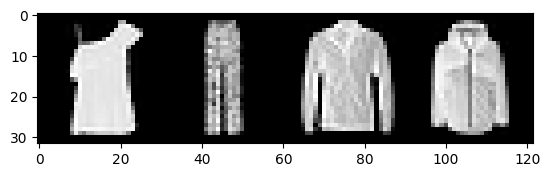

Labels: Shirt        Trouser      Coat         Coat        
Training Data: 48000 samples
Validation Data: 12000 samples
Test Data: 10000 samples


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set up device (use GPU to speed up computations if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for training, validation, and testing
transform = transforms.Compose([
    transforms.ToTensor()  # Normalize to standardize data scale
])


# Loading FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Print the size of the datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Function to show images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')  # Transpose dimensions and display
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(train_dataset, batch_size=4, shuffle=True))
images, labels = next(dataiter)

# Show sample images
print('Sample images:')
imshow(torchvision.utils.make_grid(images))

# Labels for FashionMNIST classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Print corresponding labels
print('Labels:', ' '.join(f'{classes[labels[j]]:12s}' for j in range(4)))


# Split training dataset into training and validation sets
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_data, validation_data = random_split(train_dataset, [train_size, validation_size])

# Display sizes of each dataset
print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(validation_data)} samples")
print(f"Test Data: {len(test_dataset)} samples")

This block defines the architecture of the convolutional variational autoencoder (CVAE). It includes classes for the encoder and decoder parts, and it sets up the overall CVAE model by combining these components.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dims)
        self.fc_var = nn.Linear(32 * 7 * 7, latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dims, 32 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 32, 7, 7)
        z = F.relu(self.conv2(z))
        z = torch.sigmoid(self.conv1(z))  # Ensures output is in [0, 1] range
        return z

class CVAE(nn.Module):
    def __init__(self, latent_dims):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


This code block defines a training function with an early stopping mechanism for a machine learning model to prevent overfitting. The EarlyStopping class tracks the validation loss, halting training if improvements cease. The function processes epochs, computes losses for a variational autoencoder (VAE), updates weights, and logs results. It saves the optimal model based on performance, ensuring efficient training and generalization. It also prepares the loss function that will be used during training, which is specific to VAEs and involves a reconstruction loss along with a KL-divergence term to handle the probabilistic nature of the model.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

def train_model(epochs, model, optimizer, train_loader, val_loader, early_stopper, device):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data)
            # Loss calculation adapted for CVAE using Binary Cross-Entropy Loss
            recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + KLD
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon, mu, log_var = model(data)
                recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')
                KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                loss = recon_loss + KLD
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses


This code block sets up the model configuration and training environment for the convolutional variational autoencoder (CVAE). It initializes the model with a specified number of latent dimensions, configures the optimizer with learning rate and weight decay parameters, and sets an early stopping mechanism to monitor validation loss and prevent overtraining. Additionally, it prepares data loaders for both the training and validation datasets with defined batch sizes and shuffling settings, ensuring the model is trained and validated effectively.








In [ ]:
# Model parameters
latent_dims = 2  # You can adjust this based on desired complexity

# Initialize the CVAE model
model = CVAE(latent_dims).to(device)

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.00001)

# Early stopping mechanism
early_stopper = EarlyStopping(patience=10, min_delta=0.001, path='checkpoint.pt')

# Setup DataLoader for the training and validation sets
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=256, shuffle=False)

This code block runs the training process for the CVAE model over a maximum of 50 epochs, capturing the training and validation losses. After training, it uses matplotlib to plot these losses, providing a visual representation of the model's performance over time. This visualization helps identify trends such as overfitting or underfitting and assess the effectiveness of the early stopping mechanism.








Epoch: 1, Training Loss: 81214.4244, Validation Loss: 72172.1085
Validation loss decreased (72172.108461 --> 72172.108461).  Saving model ...
Epoch: 2, Training Loss: 71393.5859, Validation Loss: 70573.0783
Validation loss decreased (72172.108461 --> 70573.078291).  Saving model ...
Epoch: 3, Training Loss: 70388.6994, Validation Loss: 69786.0200
Validation loss decreased (70573.078291 --> 69786.020030).  Saving model ...
Epoch: 4, Training Loss: 69913.5010, Validation Loss: 69769.3014
Validation loss decreased (69786.020030 --> 69769.301363).  Saving model ...
Epoch: 5, Training Loss: 69671.8339, Validation Loss: 69463.8002
Validation loss decreased (69769.301363 --> 69463.800199).  Saving model ...
Epoch: 6, Training Loss: 69482.0366, Validation Loss: 69134.6807
Validation loss decreased (69463.800199 --> 69134.680685).  Saving model ...
Epoch: 7, Training Loss: 69387.7647, Validation Loss: 69005.6388
Validation loss decreased (69134.680685 --> 69005.638797).  Saving model ...
Epoch:

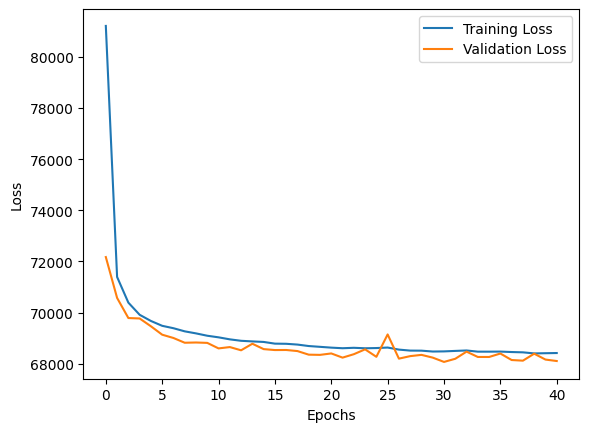

In [ ]:
train_losses, val_losses = train_model(epochs=50, model=model, optimizer=optimizer, train_loader=train_loader, val_loader=validation_loader, early_stopper=early_stopper, device=device)

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This code block defines a function to visualize the reconstruction capabilities of the trained CVAE model. It first sets the model to evaluation mode, then processes a batch of images from the provided data loader. Each original image and its reconstructed counterpart are displayed side-by-side using matplotlib, allowing for a direct visual comparison. This visualization is helpful for assessing the model's ability to capture and reconstruct the essential features of the input data. Finally, the function is called to show reconstructed images from the validation dataset.

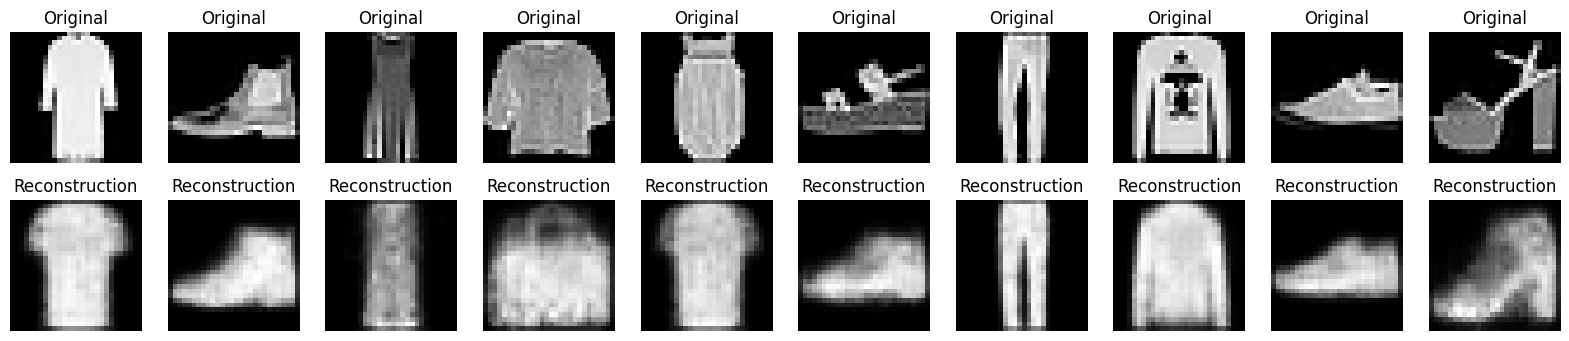

In [ ]:
def visualize_reconstruction(model, device, data_loader):
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        images, _ = next(dataiter)
        images = images.to(device)
        recon, _, _ = model(images)
        images = images.cpu()
        recon = recon.cpu()

        fig, axs = plt.subplots(2, 10, figsize=(20, 4))
        for i in range(10):
            axs[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
            axs[0, i].set_title("Original")
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
            axs[1, i].set_title("Reconstruction")
            axs[1, i].axis('off')
        plt.show()

# Visualize some results
visualize_reconstruction(model, device, validation_loader)

This code block includes a function that visualizes the latent space manifold of a trained variational autoencoder (VAE). The function generates a grid of latent vectors and uses the decoder of the VAE to transform these vectors into images. It then arranges and plots these images in a grid that corresponds to their positions in the latent space, providing a visual representation of how different latent vectors are decoded into images. This visualization is crucial for understanding the diversity and continuity of the data representations learned by the VAE. After defining the function, it is executed using the decoder of the trained model, effectively demonstrating the model's ability to generate diverse images from its learned latent space.

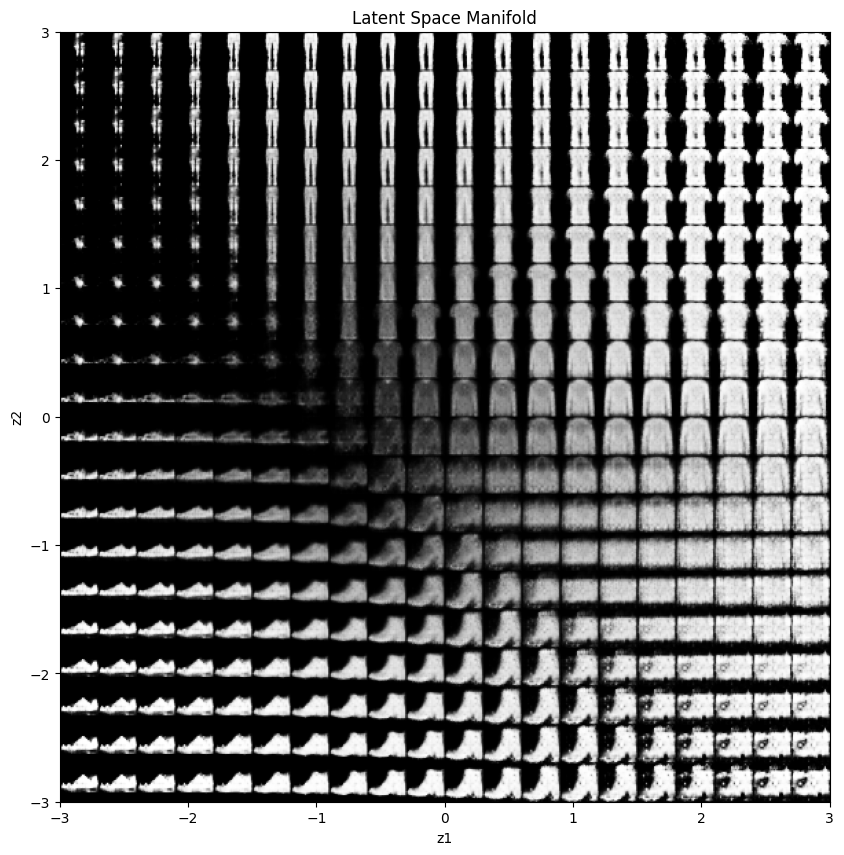

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_latent_space(decoder, device, grid_size=20, grid_scale=3.0):
    # Create a grid of latent variables (z1, z2) to be transformed by the decoder
    image_grid = np.empty((28 * grid_size, 28 * grid_size))
    for i, z1 in enumerate(np.linspace(-grid_scale, grid_scale, grid_size)):
        for j, z2 in enumerate(np.linspace(-grid_scale, grid_scale, grid_size)):
            # Create a latent vector and decode it
            z = torch.tensor([[z1, z2]], dtype=torch.float32).to(device)
            image = decoder(z).detach().cpu().numpy()
            image = image.reshape(28, 28)
            image_grid[(grid_size-i-1)*28:(grid_size-i)*28, j*28:(j+1)*28] = image

    # Plot the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, extent=(-grid_scale, grid_scale, -grid_scale, grid_scale), cmap='gray')
    plt.title("Latent Space Manifold")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(False)
    plt.show()

# Example of how to use this function
# Assuming `model` is your trained VAE model, and `device` is your computation device (cuda or cpu)
visualize_latent_space(model.decoder, device)

This code block defines a function generate_and_compare_images that visualizes the effectiveness of a trained variational autoencoder (VAE) by generating new images from random latent vectors and comparing them with the closest existing images from the training dataset. The function starts by generating a new image from a random latent vector, then calculates embeddings for the entire training set to find the closest matches in the latent space. These images are displayed alongside the newly generated image to visually assess the similarity and quality of the VAE's generative capabilities.

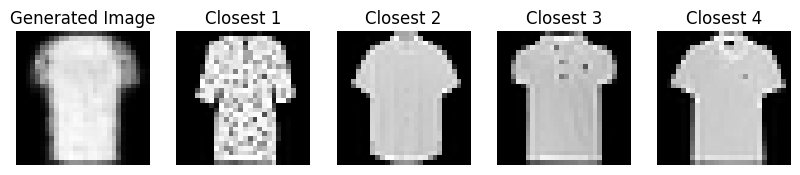

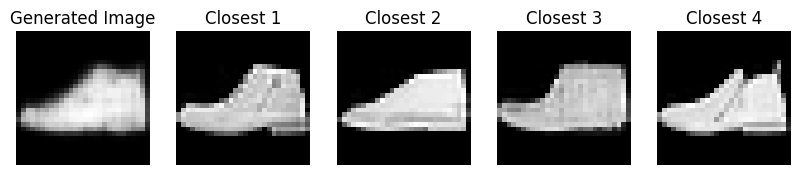

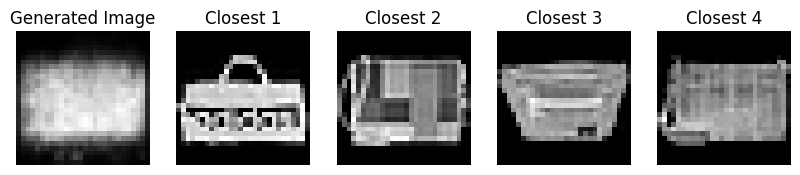

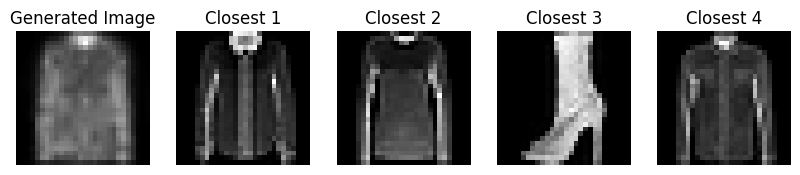

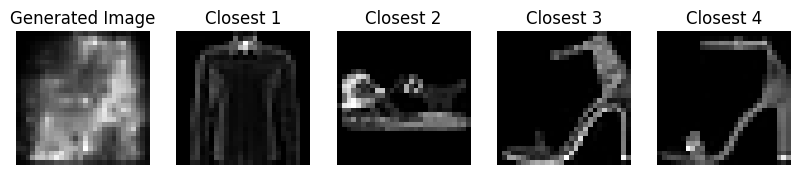

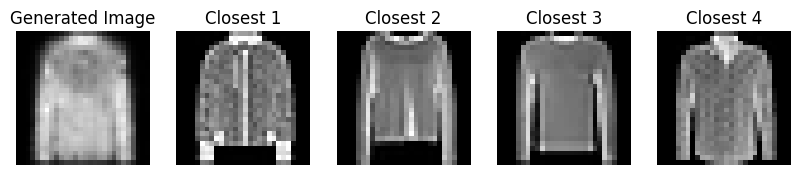

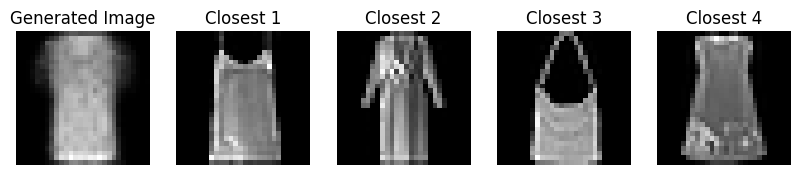

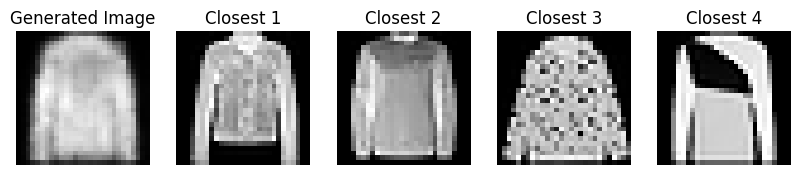

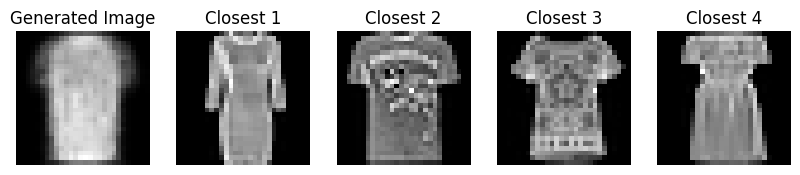

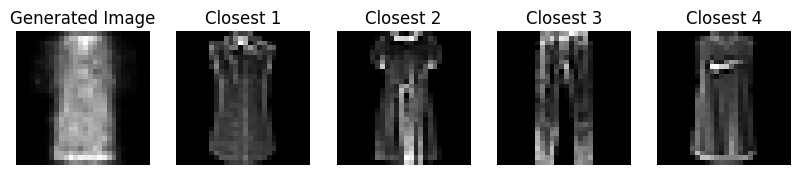

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def generate_and_compare_images(model, train_dataset, device, num_closest=4):
    # Generate a new image from a random latent vector
    z = torch.randn(1, model.encoder.fc_mu.out_features).to(device)
    with torch.no_grad():
        new_image = model.decoder(z).view(28, 28).cpu()

    # Compute or load precomputed latent vectors for the training set
    model.eval()
    embeddings = []
    data_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    for data, _ in data_loader:
        data = data.to(device)
        mu, _ = model.encoder(data)
        embeddings.append(mu.detach().cpu())
    embeddings = torch.cat(embeddings, dim=0)

    # Calculate distances and find closest images
    distances = torch.norm(embeddings - z.cpu(), dim=1)
    closest_indices = torch.argsort(distances)[:num_closest]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, num_closest + 1, 1)
    plt.imshow(new_image, cmap='gray')
    plt.title("Generated Image")
    plt.axis('off')

    for i, idx in enumerate(closest_indices, start=2):
        image, _ = train_dataset[idx]
        plt.subplot(1, num_closest + 1, i)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Closest {i-1}")
        plt.axis('off')

    plt.show()

# Example usage:
# Assuming `model` is your trained VAE, `train_dataset` is the dataset, and `device` is your computation device
for i in range(10):
  generate_and_compare_images(model, train_dataset, device)